In [1]:
import numpy as np
import pandas as pd
import os, zipfile
from pathlib import Path

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model,layers
from tensorflow.keras.layers import Dense, Flatten, Activation
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input
import tensorflow as tf
import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import cv2

In [2]:
print("Are datasets unziped?: ", os.path.isdir("./surface-crack-detection/"))

if not os.path.isdir("./surface-crack-detection/"):
    zip = zipfile.ZipFile("./surface-crack-detection.zip")
    zip.extractall("./")
    zip.close()

Are datasets unziped?:  True


In [3]:
positive_dir = Path('./surface-crack-detection/Positive')
negative_dir = Path('./surface-crack-detection/Negative')

In [4]:
def generate_df(image_dir, label):
    filepaths = pd.Series(list(image_dir.glob(r'*.jpg')), name='Filepath').astype(str)
    labels = pd.Series(label, name='Label', index=filepaths.index)
    df = pd.concat([filepaths, labels], axis=1)
    return df

# ResNet50 (64 x 64)

In [5]:
positive_df = generate_df(positive_dir, label="POSITIVE")
negative_df = generate_df(negative_dir, label="NEGATIVE")

df = pd.concat([positive_df, negative_df], axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
df

,Filepath,Label
0,surface-crack-detection\Positive\03842.jpg,POSITIVE
1,surface-crack-detection\Positive\12899_1.jpg,POSITIVE
2,surface-crack-detection\Positive\15033_1.jpg,POSITIVE
3,surface-crack-detection\Negative\16782.jpg,NEGATIVE
4,surface-crack-detection\Positive\09202.jpg,POSITIVE
...,...,...
39995,surface-crack-detection\Positive\07814.jpg,POSITIVE
39996,surface-crack-detection\Negative\12512.jpg,NEGATIVE
39997,surface-crack-detection\Positive\05193.jpg,POSITIVE
39998,surface-crack-detection\Positive\12173_1.jpg,POSITIVE


In [6]:
train_df, test_df = train_test_split(df,train_size=0.8,shuffle=True,random_state=777)

In [7]:
train_gen = ImageDataGenerator(rescale=1./255, validation_split=0.1)
test_gen = ImageDataGenerator(rescale=1./255)

In [8]:
img_size = (64, 64)

train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=777,
    subset='training')

val_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=777,
    subset='validation')

test_data = train_gen.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=777)

Found 28800 validated image filenames belonging to 2 classes.
Found 3200 validated image filenames belonging to 2 classes.
Found 8000 validated image filenames belonging to 2 classes.


In [9]:
# resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(64,64,3))
resnet = ResNet50(include_top=False, weights=None, input_shape=(64,64,3))
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

In [10]:
for layer in resnet.layers:
    layer.trainable=False

In [11]:
x = Flatten()(resnet.output)
x = Dense(512, activation='relu')(x)
x = Dense(512, activation='relu')(x)
prediction = Dense(2, activation='sigmoid')(x)
model = Model(inputs=resnet.input, outputs=prediction)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']             
                                                                                              

In [12]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(train_data,
                    validation_data=val_data,
                    batch_size=100,
                    epochs=50,
                    callbacks=[tf.keras.callbacks.EarlyStopping(
                                monitor='val_loss',
                                patience=3,
                                restore_best_weights=True)
                            ]
                    )

Epoch 1/50
900/900 [==============================] - 22s 19ms/step - loss: 0.2289 - accuracy: 0.8995 - val_loss: 0.1183 - val_accuracy: 0.9572
Epoch 2/50
900/900 [==============================] - 16s 17ms/step - loss: 0.1305 - accuracy: 0.9516 - val_loss: 0.1616 - val_accuracy: 0.9394
Epoch 3/50
900/900 [==============================] - 16s 18ms/step - loss: 0.1146 - accuracy: 0.9601 - val_loss: 0.0974 - val_accuracy: 0.9672
Epoch 4/50
900/900 [==============================] - 16s 18ms/step - loss: 0.1089 - accuracy: 0.9621 - val_loss: 0.0916 - val_accuracy: 0.9675
Epoch 5/50
900/900 [==============================] - 16s 18ms/step - loss: 0.1042 - accuracy: 0.9649 - val_loss: 0.0943 - val_accuracy: 0.9697
Epoch 6/50
900/900 [==============================] - 16s 18ms/step - loss: 0.0981 - accuracy: 0.9661 - val_loss: 0.0933 - val_accuracy: 0.9694
Epoch 7/50
900/900 [==============================] - 16s 18ms/step - loss: 0.0972 - accuracy: 0.9669 - val_loss: 0.0837 - val_accuracy:

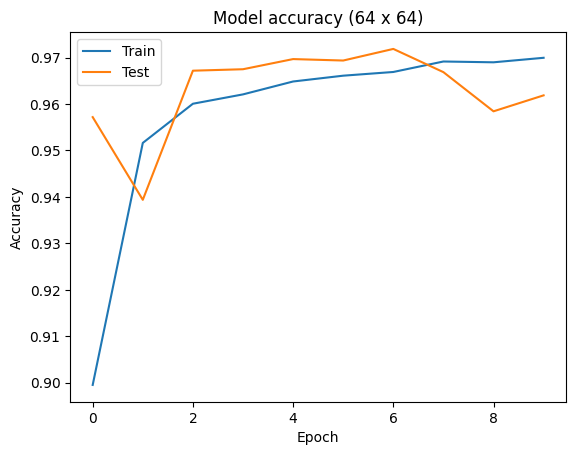

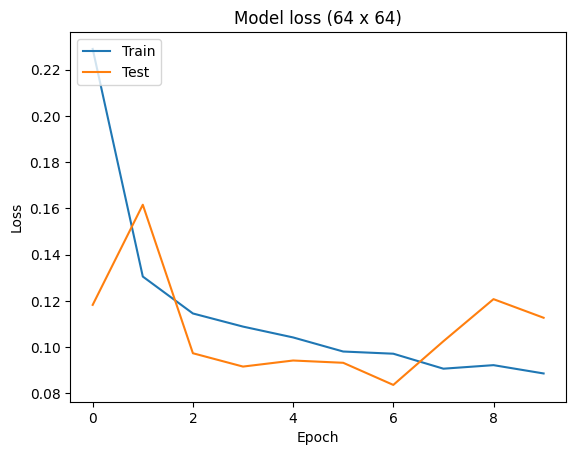

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy (64 x 64)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss (64 x 64)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [14]:
def evaluate_model(model, test_data):
    
    results = model.evaluate(test_data, verbose=0)
    loss = results[0]
    acc = results[1]
    
    print("    Test Loss: {:.5f}".format(loss))
    print("Test Accuracy: {:.2f}%".format(acc * 100))

In [15]:
evaluate_model(model, test_data)

    Test Loss: 0.08700
Test Accuracy: 97.06%


In [16]:
y_pred = np.squeeze((model.predict(test_data) >= 0.5).astype(np.int))
y_pred = np.argmax(y_pred, axis=1)
clr = classification_report(test_data.labels, y_pred, target_names=["NEGATIVE", "POSITIVE"])

print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.98      0.96      0.97      3978
    POSITIVE       0.96      0.98      0.97      4022

    accuracy                           0.97      8000
   macro avg       0.97      0.97      0.97      8000
weighted avg       0.97      0.97      0.97      8000



C:\Users\mmqq2\AppData\Local\Temp\ipykernel_11192\1358773387.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pred = np.squeeze((model.predict(test_data) >= 0.5).astype(np.int))


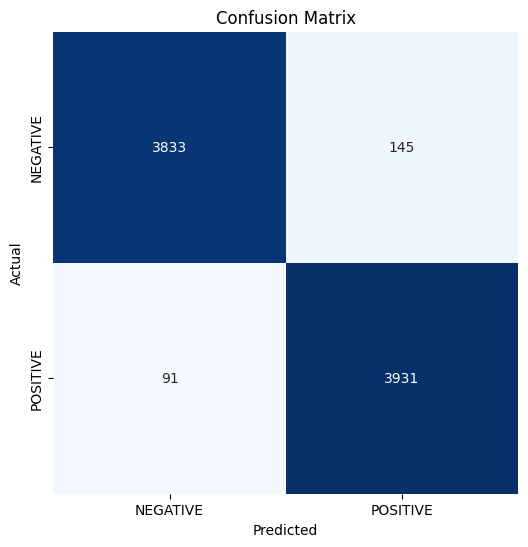

In [17]:
cm = confusion_matrix(test_data.labels, y_pred)
    
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
plt.yticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ResNet50 + VGG16 (64 x 64)

In [18]:
positive_df = generate_df(positive_dir, label="POSITIVE")
negative_df = generate_df(negative_dir, label="NEGATIVE")

In [19]:
df = pd.concat([positive_df, negative_df], axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
df

,Filepath,Label
0,surface-crack-detection\Positive\03842.jpg,POSITIVE
1,surface-crack-detection\Positive\12899_1.jpg,POSITIVE
2,surface-crack-detection\Positive\15033_1.jpg,POSITIVE
3,surface-crack-detection\Negative\16782.jpg,NEGATIVE
4,surface-crack-detection\Positive\09202.jpg,POSITIVE
...,...,...
39995,surface-crack-detection\Positive\07814.jpg,POSITIVE
39996,surface-crack-detection\Negative\12512.jpg,NEGATIVE
39997,surface-crack-detection\Positive\05193.jpg,POSITIVE
39998,surface-crack-detection\Positive\12173_1.jpg,POSITIVE


In [20]:
train_df, test_df = train_test_split(df,train_size=0.8,shuffle=True,random_state=777)
train_gen = ImageDataGenerator(rescale=1./255, validation_split=0.1)
test_gen = ImageDataGenerator(rescale=1./255)

In [21]:
img_size = (64, 64)

train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=777,
    subset='training')

val_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=777,
    subset='validation')

test_data = train_gen.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=777)

Found 28800 validated image filenames belonging to 2 classes.
Found 3200 validated image filenames belonging to 2 classes.
Found 8000 validated image filenames belonging to 2 classes.


In [22]:
inputs = keras.Input(shape=(64, 64, 3), name="input")
resnet = ResNet50(include_top=False, weights=None, input_tensor=inputs)
for layer in resnet.layers:
    layer.trainable = False
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input[0][0]']                  
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

In [23]:
vgg = VGG16(include_top=False, weights=None, input_tensor=inputs)
for layer in vgg.layers:
    layer.trainable = False
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [24]:
merged_output = keras.layers.Concatenate()([resnet.output, vgg.output])
merged_output = keras.layers.GlobalAveragePooling2D()(merged_output)
x = Flatten()(merged_output)
x = Dense(512, activation='relu')(x)
x = Dense(512, activation='relu')(x)
prediction = Dense(2, activation='sigmoid')(x)
model = Model(inputs=resnet.input, outputs=prediction)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input[0][0]']                  
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']             
                                                                                            

In [25]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(train_data,
                    validation_data=val_data,
                    batch_size=100,
                    epochs=50,
                    callbacks=[tf.keras.callbacks.EarlyStopping(
                                monitor='val_loss',
                                patience=3,
                                restore_best_weights=True)
                            ]
                    )

Epoch 1/50
900/900 [==============================] - 28s 29ms/step - loss: 0.4740 - accuracy: 0.7362 - val_loss: 0.1872 - val_accuracy: 0.9278
Epoch 2/50
900/900 [==============================] - 25s 28ms/step - loss: 0.1687 - accuracy: 0.9361 - val_loss: 0.1477 - val_accuracy: 0.9428
Epoch 3/50
900/900 [==============================] - 25s 27ms/step - loss: 0.1486 - accuracy: 0.9423 - val_loss: 0.1257 - val_accuracy: 0.9506
Epoch 4/50
900/900 [==============================] - 25s 27ms/step - loss: 0.1426 - accuracy: 0.9470 - val_loss: 0.1253 - val_accuracy: 0.9516
Epoch 5/50
900/900 [==============================] - 26s 28ms/step - loss: 0.1365 - accuracy: 0.9484 - val_loss: 0.1377 - val_accuracy: 0.9453
Epoch 6/50
900/900 [==============================] - 25s 28ms/step - loss: 0.1321 - accuracy: 0.9507 - val_loss: 0.1108 - val_accuracy: 0.9603
Epoch 7/50
900/900 [==============================] - 25s 28ms/step - loss: 0.1306 - accuracy: 0.9513 - val_loss: 0.1116 - val_accuracy:

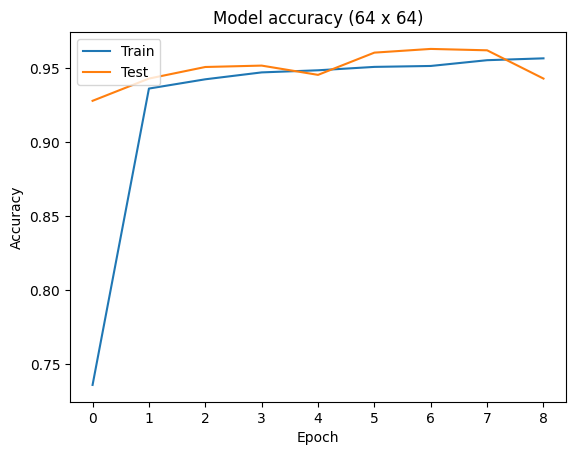

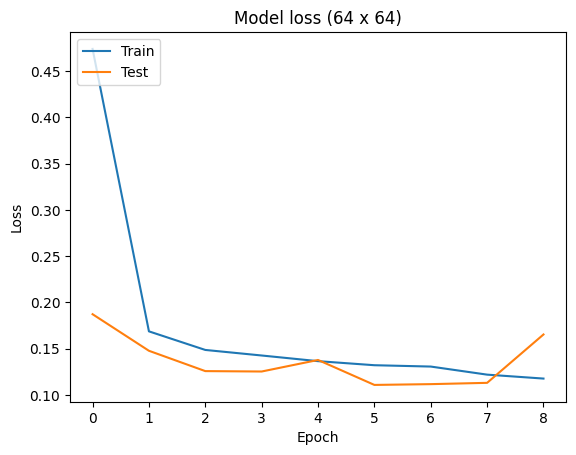

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy (64 x 64)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss (64 x 64)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [27]:
def evaluate_model(model, test_data):
    
    results = model.evaluate(test_data, verbose=0)
    loss = results[0]
    acc = results[1]
    
    print("    Test Loss: {:.5f}".format(loss))
    print("Test Accuracy: {:.2f}%".format(acc * 100))
    
evaluate_model(model, test_data)

    Test Loss: 0.11112
Test Accuracy: 95.97%


In [28]:
y_pred = np.squeeze((model.predict(test_data) >= 0.5).astype(np.int))
y_pred = np.argmax(y_pred, axis=1)
clr = classification_report(test_data.labels, y_pred, target_names=["NEGATIVE", "POSITIVE"])

print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.95      0.97      0.96      3978
    POSITIVE       0.97      0.95      0.96      4022

    accuracy                           0.96      8000
   macro avg       0.96      0.96      0.96      8000
weighted avg       0.96      0.96      0.96      8000



C:\Users\mmqq2\AppData\Local\Temp\ipykernel_11192\1358773387.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pred = np.squeeze((model.predict(test_data) >= 0.5).astype(np.int))


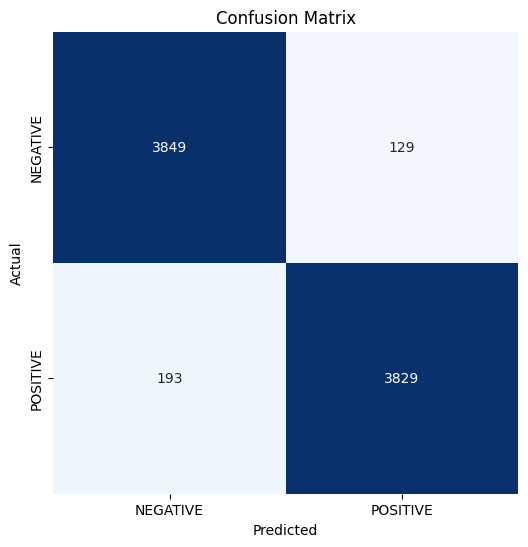

In [29]:
cm = confusion_matrix(test_data.labels, y_pred)
    
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
plt.yticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()